**Note**

This is an implementation of our improvement for the auto rec algorithm introduced in the following paper:

Sedhain, Suvash, et al. "Autorec: Autoencoders meet collaborative filtering." Proceedings of the 24th International Conference on World Wide Web. ACM, 2015

The code is based on the paper's github repository:
https://github.com/gtshs2/Autorec

**imports**

In [1]:
from google.colab import drive
import tensorflow as tf
import time
import numpy as np
import os
import math
!pip install --quiet zipfile36
import zipfile
import requests
import pandas as pd
import argparse
from numpy import save
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import load


**artifacts files**

In [3]:
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/'
hist_file100KAutoRec = path + 'hist_100KAutoRec.npy'
params_file100KAutoRec = path + 'params_100KAutoRec.npy'
hist_file1MAutoRec = path + 'hist_1MAutoRec.npy'
params_file1MAutoRec = path + 'params_1MAutoRec.npy'
hist_file100KAutoRecNew = path + 'hist_100KAutoRecNew.npy'
params_file100KAutoRecNew = path + 'params_100KAutoRecNew.npy'
hist_file1MAutoRecNew = path + 'hist_1MAutoRecNew.npy'
params_file1MAutoRecNew = path + 'params_1MAutoRecNew.npy'

hist_rmse_Mf_1M = path + 'hist_rmse-MF.npy'
hist_Mf_1M = path + 'hist-MF.npy'
params_Mf_1M = path + 'params-MF.npy'

Mounted at /content/drive


**Auto Encoder**

In [4]:
class AutoRec():
    def __init__(self,sess,hidden_neuron,
                      lambda_value,
                      train_epoch,
                      batch_size,
                      optimizer_method,
                      grad_clip,
                      base_lr,
                      decay_epoch_step,
                      random_seed,
                      display_step,
                      num_users,num_items,
                      R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,
                      user_train_set, item_train_set, user_test_set, item_test_set, user_info, calc_new_metrics, num_users_U30, num_users_U20, newAutoRec,test_maskU30_R, test_maskU20_R,
                      result_path):

        self.sess = sess
        self.newAutoRec = newAutoRec;
        self.calc_new_metrics = calc_new_metrics
        self.num_users_U0 = num_users_U30
        self.num_users_U20 = num_users_U20
        self.num_users = num_users
        self.num_items = num_items
        self.num_items_and_features = num_items + (newAutoRec *user_info.shape[1])
        self.num_of_user_features = (newAutoRec * user_info.shape[1])
        self.R = R
        self.mask_R = mask_R
        self.C = C
        self.train_R = train_R
        self.train_mask_R = train_mask_R
        self.test_R = test_R
        self.test_mask = (test_mask_R, test_maskU30_R, test_maskU20_R)
        self.test_mask_R = test_mask_R
        self.num_train_ratings = num_train_ratings
        self.num_test_ratings = num_test_ratings
        self.user_info = user_info
        self.user_train_set = user_train_set
        self.item_train_set = item_train_set
        self.user_test_set = user_test_set
        self.item_test_set = item_test_set

        self.hidden_neuron = hidden_neuron
        self.train_epoch = train_epoch
        self.batch_size = batch_size
        self.num_batch = int(math.ceil(self.num_users / float(self.batch_size)))

        self.base_lr = base_lr
        self.optimizer_method = optimizer_method
        self.display_step = display_step
        self.random_seed = random_seed

        self.global_step = tf.Variable(0, trainable=False)
        self.decay_epoch_step = decay_epoch_step
        self.decay_step = self.decay_epoch_step * self.num_batch
        self.lr = tf.train.exponential_decay(self.base_lr, self.global_step,
                                                   self.decay_step, 0.96, staircase=True)
        self.lambda_value = lambda_value

        self.train_cost_list = []
        self.test_cost_list = []
        self.test_rmse_list = []

        self.result_path = result_path
        self.grad_clip = grad_clip

    def run(self):
        self.prepare_model()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        for epoch_itr in range(self.train_epoch):
            self.train_model(epoch_itr)
            self.test_model(epoch_itr)
        self.make_records()

    def prepare_model(self):
        self.input_R = tf.placeholder(dtype=tf.float32, shape=[None, self.num_items_and_features], name="input_R")
        if self.newAutoRec:
          self.user_features = tf.placeholder(dtype=tf.float32, shape=[None, self.num_of_user_features], name="user_features")
        self.input_mask_R = tf.placeholder(dtype=tf.float32, shape=[None, self.num_items_and_features], name="input_mask_R")
        

        V = tf.get_variable(name="V", initializer=tf.truncated_normal(shape=[self.num_items_and_features, self.hidden_neuron],
                                         mean=0, stddev=0.03),dtype=tf.float32)
        W = tf.get_variable(name="W", initializer=tf.truncated_normal(shape=[self.hidden_neuron + self.num_of_user_features, self.num_items],
                                         mean=0, stddev=0.03),dtype=tf.float32)

        mu = tf.get_variable(name="mu", initializer=tf.zeros(shape=self.hidden_neuron),dtype=tf.float32)
        b = tf.get_variable(name="b", initializer=tf.zeros(shape=self.num_items), dtype=tf.float32)


        pre_Encoder = tf.matmul(self.input_R,V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        if self.newAutoRec:
          post_Encoder = tf.concat([self.Encoder, self.user_features], 1)
          pre_Decoder = tf.matmul(post_Encoder,W) + b
          self.Decoder = tf.identity(pre_Decoder)
        else:
          pre_Decoder = tf.matmul(self.Encoder,W) + b
          self.Decoder = tf.identity(pre_Decoder)     

        pre_rec_cost = tf.multiply((self.input_R[:,0:self.num_items] - self.Decoder) , self.input_mask_R[:,0:self.num_items])
        rec_cost = tf.square(self.l2_norm(pre_rec_cost))
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost

        self.cost = rec_cost + reg_cost

        if self.optimizer_method == "Adam":
            optimizer = tf.train.AdamOptimizer(self.lr)
        elif self.optimizer_method == "RMSProp":
            optimizer = tf.train.RMSPropOptimizer(self.lr)
        else:
            raise ValueError("Optimizer Key ERROR")

        if self.grad_clip:
            gvs = optimizer.compute_gradients(self.cost)
            capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs]
            self.optimizer = optimizer.apply_gradients(capped_gvs, global_step=self.global_step)
        else:
            self.optimizer = optimizer.minimize(self.cost, global_step=self.global_step)

    def train_model(self,itr):
        start_time = time.time()
        random_perm_doc_idx = np.random.permutation(self.num_users)
        batch_cost = 0
        for i in range(self.num_batch):
            if i == self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size:]
            elif i < self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size : (i+1) * self.batch_size]
            if self.newAutoRec:
              _, Cost = self.sess.run(
                  [self.optimizer, self.cost],
                  feed_dict={self.input_R: self.train_R[batch_set_idx, :],
                            self.input_mask_R: self.train_mask_R[batch_set_idx, :],
                            self.user_features: self.user_info[batch_set_idx, :]})
            else:
              _, Cost = self.sess.run(
                  [self.optimizer, self.cost],
                  feed_dict={self.input_R: self.train_R[batch_set_idx, :],
                            self.input_mask_R: self.train_mask_R[batch_set_idx, :]})

            batch_cost = batch_cost + Cost
        self.train_cost_list.append(batch_cost)

        if (itr+1) % self.display_step == 0:
            print ("Training //", "Epoch %d //" % (itr), " Total cost = {:.2f}".format(batch_cost),
               "Elapsed time : %d sec" % (time.time() - start_time))

    def test_model(self,itr):
        start_time = time.time()
        ind = [0]
        if self.calc_new_metrics:
          ind = [1,2]
        for i in ind:
          cost_list = []
          if self.newAutoRec:
            Cost,Decoder = self.sess.run(
                [self.cost,self.Decoder],
                feed_dict={self.input_R: self.test_R,
                          self.input_mask_R: self.test_mask[i],
                          self.user_features: self.user_info})
          else:
            Cost,Decoder = self.sess.run(
                [self.cost,self.Decoder],
                feed_dict={self.input_R: self.test_R,
                          self.input_mask_R: self.test_mask[i]})
            
          self.test_cost_list.append(Cost)

          if (itr+1) % self.display_step == 0:
              Estimated_R = Decoder.clip(min=1, max=5)
              unseen_user_test_list = list(self.user_test_set - self.user_train_set)
              unseen_item_test_list = list(self.item_test_set - self.item_train_set)

              for user in unseen_user_test_list:
                  for item in unseen_item_test_list:
                      if self.test_mask[i][user,item] == 1: # exist in test set
                          Estimated_R[user,item] = 3

              pre_numerator = np.multiply((Estimated_R - self.test_R[:,0:self.num_items]), self.test_mask[i][:,0:self.num_items])
              numerator = np.sum(np.square(pre_numerator))
              denominator = self.num_test_ratings
              if i == 1:
                denominator = self.num_users_U30
              elif i==2:
                denominator = self.num_users_U20
              RMSE = np.sqrt(numerator / float(denominator))

              self.test_rmse_list.append(RMSE)

              print ("Testing //", "Epoch %d //" % (itr), " Total cost = {:.2f}".format(Cost), " RMSE = {:.5f}".format(RMSE),
                    "Elapsed time : %d sec" % (time.time() - start_time))
              print ("=" * 100)

    def make_records(self):
        if not os.path.exists(self.result_path):
            os.makedirs(self.result_path)

        basic_info = self.result_path + "basic_info.txt"
        train_record = self.result_path + "train_record.txt"
        test_record = self.result_path + "test_record.txt"

        with open (train_record,'w') as f:
            f.write(str("Cost:"))
            f.write('\t')
            for itr in range(len(self.train_cost_list)):
                f.write(str(self.train_cost_list[itr]))
                f.write('\t')
            f.write('\n')

        with open (test_record,'w') as g:
            g.write(str("Cost:"))
            g.write('\t')
            for itr in range(len(self.test_cost_list)):
                g.write(str(self.test_cost_list[itr]))
                g.write('\t')
            g.write('\n')

            g.write(str("RMSE:"))
            for itr in range(len(self.test_rmse_list)):
                g.write(str(self.test_rmse_list[itr]))
                g.write('\t')
            g.write('\n')


    def l2_norm(self,tensor):
        return tf.sqrt(tf.reduce_sum(tf.square(tensor)))



**read data - 1 function for movieLens1M and 1 function to movieLems100K**

In [5]:
def read_rating_100K(path, num_users, num_items,num_total_ratings, a, b, train_ratio, newAutoRec, newMetrics):
  url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
  zip_name = 'ml-100k.zip'
  data_dir = 'ml-100k/'

  r = requests.get(url, allow_redirects=True)
  open(zip_name, 'wb').write(r.content)

  with zipfile.ZipFile(zip_name,"r") as zip_ref:
      zip_ref.extractall()

  cols_data = ['user_id','item_id','rating','timestamp']
  cols_user = ['user_id','age','gender','occupation','zip code']
  cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
              'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
              'Sci_Fi','Thriller','War','Western']

  df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
  df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
  df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
  ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)

  df_folds = {i:
        {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
          'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
        } for i in range(1,6)} 

  def fold2df(i):
      train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
      test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
      return train,test 

  def getfulldf(train_fold,test_fold):
      train = ratings.copy()
      train[:] = 0
      test = train.copy()
      
      train.loc[train_fold.index,train_fold.columns] = train_fold.values
      test.loc[test_fold.index,test_fold.columns] = test_fold.values
      return train,test

  fold = 1
  train,test = getfulldf(*fold2df(1))

  a = df_users.to_numpy()
  user_info = np.zeros((943,31))
  if newAutoRec:
    uni = df_users['occupation'].unique()
    dic = {}
    for i in range(len(uni)):
      dic[uni[i]] =i + 10
    for user_index in range(a.shape[0]):
      #add gender 
      if a[user_index][2] == 'M':
        user_info[user_index][0] = 1
      else:
        user_info[user_index][1] = 1
      #add age
      if int(a[user_index][1]) < 18:
        user_info[user_index][2] = 1
      elif int(a[user_index][1]) < 25:
        user_info[user_index][3] = 1
      elif int(a[user_index][1]) < 35:
        user_info[user_index][4] = 1 
      elif int(a[user_index][1]) < 45:
        user_info[user_index][5] = 1
      elif int(a[user_index][1]) < 50:
        user_info[user_index][6] = 1
      elif int(a[user_index][1]) < 56:
        user_info[user_index][7] = 1
      else:
        user_info[user_index][8] = 1
      #add occupations
      user_info[user_index][dic[a[user_index][3]]] = 1
  user_info = user_info.tolist()
  train_R = train.to_numpy()
  train_mask_R = np.where(train_R > 0 , 1 , 0)
  test_R = test.to_numpy()
  test_mask_R = np.where(test_R > 0 , 1 , 0)

  if newAutoRec:
    train_temp = train_R.tolist()
    train_mask_temp = train_mask_R.tolist()
    test_temp = test_R.tolist()
    test_mask_temp = test_mask_R.tolist()
    
    for i in range(ratings.shape[0]):
      train_temp[i]+=user_info[i]
      test_temp[i]+=user_info[i]
      train_mask_temp[i]+= np.ones(31).tolist()
      test_mask_temp[i]+= np.ones(31).tolist()
    
    train_R = np.array(train_temp)
    train_mask_R = np.array(train_mask_temp)
    test_R = np.array(test_temp)
    test_mask_R = np.array(test_mask_temp)


  R = ratings.to_numpy()
  mask_R = np.where(R > 0 , 1 , 0)
  C = None
  num_train_ratings = sum(sum(train_mask_R))
  num_test_ratings = sum(sum(test_mask_R))
  user_train_set= set()
  user_test_set= set()
  item_train_set= set()
  item_test_set= set()
  for user_idx in range(train_mask_R.shape[0]):
    if sum(train_mask_R[user_idx])>0:
        user_train_set.add(user_idx)
    if sum(train_mask_R[user_idx])>0:
        user_test_set.add(user_idx)

  for item_idx in range(train_mask_R.shape[1]):
    if sum(train_mask_R[:,item_idx])>0:
        item_train_set.add(item_idx)
    if sum(train_mask_R[:,item_idx])>0:
        item_test_set.add(item_idx)


  test_maskU30_R = test_mask_R.copy()
  test_maskU20_R = test_mask_R.copy()
  num_users_U30 = num_users
  num_users_U20 = num_users
  for i in range(num_users):
    if sum(train_mask_R[i]) > 13:
      num_users_U30 -= 1
      test_maskU30_R[i] *= 0
    if sum(train_mask_R[i]) > 23:
      num_users_U20 -= 1
      test_maskU20_R[i] *= 0
  return ratings.to_numpy(), mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
    user_train_set,item_train_set,user_test_set,item_test_set, np.array(user_info), test_maskU30_R, test_maskU20_R, num_users_U30, num_users_U20

def read_rating(path, num_users, num_items,num_total_ratings, a, b, train_ratio, newAutoRec, newMetrics):
    url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
    zip_name = 'ml-1m.zip'
    data_dir = 'ml-1m/'
    print(newAutoRec)
    r = requests.get(url, allow_redirects=True)
    open(zip_name, 'wb').write(r.content)

    with zipfile.ZipFile(zip_name,"r") as zip_ref:
      zip_ref.extractall()

    fp = open(data_dir + "ratings.dat")

    user_train_set = set()
    user_test_set = set()
    item_train_set = set()
    item_test_set = set()
    num_items_and_feautues = num_items + (newAutoRec * 30);
    R = np.zeros((num_users,num_items))
    mask_R = np.zeros((num_users, num_items))
    C = np.ones((num_users, num_items)) * b

    train_R = np.zeros((num_users, num_items_and_feautues))
    test_R = np.zeros((num_users, num_items_and_feautues))

    train_mask_R = np.zeros((num_users, num_items_and_feautues))
    test_mask_R = np.zeros((num_users, num_items_and_feautues))

    user_info = np.zeros((num_users, 30))

    random_perm_idx = np.random.permutation(num_total_ratings)
    train_idx = random_perm_idx[0:int(num_total_ratings*train_ratio)]
    test_idx = random_perm_idx[int(num_total_ratings*train_ratio):]

    num_train_ratings = len(train_idx)
    num_test_ratings = len(test_idx)

    lines = fp.readlines()
    for line in lines:
        user,item,rating,_ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        R[user_idx,item_idx] = int(rating)
        mask_R[user_idx,item_idx] = 1
        C[user_idx,item_idx] = a

    ''' Train '''
    for itr in train_idx:
        line = lines[itr]
        user,item,rating,_ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        train_R[user_idx,item_idx] = int(rating)
        train_mask_R[user_idx,item_idx] = 1

        user_train_set.add(user_idx)
        item_train_set.add(item_idx)

    ''' Test '''
    for itr in test_idx:
        line = lines[itr]
        user, item, rating, _ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        test_R[user_idx, item_idx] = int(rating)
        test_mask_R[user_idx, item_idx] = 1

        user_test_set.add(user_idx)
        item_test_set.add(item_idx)
    
    ''' Add user features to train and test '''
    ''' UserID::Gender::Age::Occupation::Zip-code '''
    m=0
    if newAutoRec:
      fp = open(data_dir + "users.dat")
      lines = fp.readlines()
      for line in lines:
          loc = num_items;
          loc_user = 0
          user,gender,age,occupation,_ = line.split("::")

          user = int(user) - 1
          #add gender
          if gender == 'M':
            train_R[user][loc] = 1
            test_R[user][loc] = 1
            train_R[user][loc + 1] = 0
            test_R[user][loc + 1] = 0
            user_info[user][loc_user] = 1
            user_info[user][loc_user + 1] = 0
          else:
            train_R[user][loc] = 0
            test_R[user][loc] = 0
            user_info[user][loc_user] = 0
            train_R[user][loc + 1] = 1
            test_R[user][loc + 1] = 1
            user_info[user][loc_user + 1] = 1

          train_mask_R[user][loc] = 1
          test_mask_R[user][loc] = 1
          train_mask_R[user][loc + 1] = 1
          test_mask_R[user][loc + 1] = 1
          loc = loc + 2
          loc_user = loc_user + 2
          #add age
          i = 0;
          if age == '1':
              i = 0
          elif age == '18':
              i = 1
          elif age == '25':
              i = 2
          elif age == '35':
              i = 3
          elif age == '45':
              i = 4
          elif age == '50':
              i = 5
          elif age == '56':
              i = 6
          for j in range(7):
            if i == j:
              train_R[user][loc+i] = 1
              test_R[user][loc+i] = 1
              user_info[user][loc_user + i] = 1
            else:
              train_R[user][loc+i] = 0
              test_R[user][loc+i] = 0
              user_info[user][loc_user + i] = 0
          loc = loc + 7;
          loc_user = loc_user + 7;
          i=0

          for i in range(21):
            if str(i) == occupation:
              train_R[user][loc+i] = 1
              train_mask_R[user][loc+i] = 1
              test_R[user][loc+i] = 1
              test_mask_R[user][loc+i] = 1
              user_info[user][loc_user + i] = 1
            else:
              train_R[user][loc+i] = 0
              train_mask_R[user][loc+i] = 0
              test_R[user][loc+i] = 0
              test_mask_R[user][loc+i] = 0
              user_info[user][loc_user + i] = 0
    test_maskU30_R = test_mask_R.copy()
    test_maskU20_R = test_mask_R.copy()

    U30 = num_users
    U20 = num_users
    lim30 = 30;
    lim20 = 20;
    if newAutoRec:
      lim30+=3
      lim20+=3
    for i in range(num_users):
      if sum(train_mask_R[i]) > lim30:
        U30 -=1
        test_maskU30_R[i] *= 0
      if sum(train_mask_R[i]) > lim20:
        U20 -=1
        test_maskU20_R[i] *= 0

    num_users_U30 =sum(sum(test_maskU30_R))
    num_users_U20 = sum(sum(test_maskU20_R))
    if newAutoRec:
      num_users_U30 -= U30*3
      num_users_U20 -= U20*3

    return R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set, user_info,test_maskU30_R,test_maskU20_R, num_users_U30, num_users_U20

**100K autorec new**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
current_time = time.time()
random_seed=1000
tf.set_random_seed(random_seed)
np.random.seed(random_seed)
newAE = 1
newMet = 0
num_users = 943; num_items = 1682; num_total_ratings = 100000; train_ratio = 0.9
result_path = './content/drive/My Drive/Colab Notebooks/results/'
R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set, user_info, test_maskU30_R, test_maskU20_R,num_users_U30, num_users_U20 \
    = read_rating_100K(path, num_users, num_items,num_total_ratings, 1, 0, train_ratio, newAE,newMet)


config = tf.ConfigProto()
config.gpu_options.allow_growth=True

hidden_neuron_l=[500, 250, 100]
lambda_valuede=1
train_epoch=400
batch_size_l=[100, 200]
optimizer_method='Adam'
grad_clip=False
base_lr_l=[1e-3 , 1e-2]
decay_epoch_step_l=[50, 20]
myModel = None
hist = []
params = []
display_step=1
for hidden_neuron in hidden_neuron_l:
  for batch_size in batch_size_l:
    for base_lr in base_lr_l:
      for decay_epoch_step in decay_epoch_step_l:
        tf.reset_default_graph()
        with tf.Session(config=config) as sess:
            myModel = AutoRec(sess,hidden_neuron,\
                              lambda_valuede,\
                              train_epoch,\
                              batch_size,\
                              optimizer_method,\
                              grad_clip,\
                              base_lr,\
                              decay_epoch_step,\
                              random_seed,\
                              display_step,\
                              num_users,num_items,\
                              R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
                              user_train_set, item_train_set, user_test_set, item_test_set, user_info,newMet, num_users_U30, num_users_U20,newAE,test_maskU30_R, test_maskU20_R,\
                              result_path)
            myModel.run()
            hist.append([myModel.train_cost_list,myModel.test_cost_list,myModel.test_rmse_list])
            params.append([hidden_neuron,batch_size,base_lr,decay_epoch_step])
            save(hist_file100KAutoRecNew, hist)
            save(params_file100KAutoRecNew, params)




**1M new autorec**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
current_time = time.time()
random_seed=1000
tf.set_random_seed(random_seed)
np.random.seed(random_seed)
newAE = 1
newMet = 0
num_users = 6040; num_items = 3952; num_total_ratings = 1000209; train_ratio = 0.9
result_path = './content/drive/My Drive/Colab Notebooks/results/'
R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set, user_info, test_maskU30_R, test_maskU20_R,num_users_U30, num_users_U20 \
    = read_rating(path, num_users, num_items,num_total_ratings, 1, 0, train_ratio,  newAE,newMet)


config = tf.ConfigProto()
config.gpu_options.allow_growth=True

hidden_neuron_l=[500, 250, 100]
lambda_valuede=1
train_epoch=200
batch_size_l=[100, 200]
optimizer_method='Adam'
grad_clip=False
base_lr_l=[1e-3 , 1e-2]
decay_epoch_step_l=[50, 20]
myModel = None
hist = []
params = []
display_step=1
for hidden_neuron in hidden_neuron_l:
  for batch_size in batch_size_l:
    for base_lr in base_lr_l:
      for decay_epoch_step in decay_epoch_step_l:
        tf.reset_default_graph()
        with tf.Session(config=config) as sess:
            myModel = AutoRec(sess,hidden_neuron,\
                              lambda_valuede,\
                              train_epoch,\
                              batch_size,\
                              optimizer_method,\
                              grad_clip,\
                              base_lr,\
                              decay_epoch_step,\
                              random_seed,\
                              display_step,\
                              num_users,num_items,\
                              R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
                              user_train_set, item_train_set, user_test_set, item_test_set, user_info,newMet, num_users_U30, num_users_U20,newAE,test_maskU30_R, test_maskU20_R,\
                              result_path)
            myModel.run()
            hist.append([myModel.train_cost_list,myModel.test_cost_list,myModel.test_rmse_list])
            params.append([hidden_neuron,batch_size,base_lr,decay_epoch_step])
            save(hist_file1MAutoRecNew, hist)
            save(params_file1MAutoRecNew, params)




**100K autorec**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
current_time = time.time()
random_seed=1000
tf.set_random_seed(random_seed)
np.random.seed(random_seed)
newAE = 0
newMet = 0
#num_users = 6040; num_items = 3952; num_total_ratings = 1000209; train_ratio = 0.9
num_users = 943; num_items = 1682; num_total_ratings = 100000; train_ratio = 0.9
result_path = './content/drive/My Drive/Colab Notebooks/results/'
R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set, user_info, test_maskU30_R, test_maskU20_R, num_users_U30, num_users_U20 \
    = read_rating_100K(path, num_users, num_items,num_total_ratings, 1, 0, train_ratio,  newAE,newMet)


config = tf.ConfigProto()
config.gpu_options.allow_growth=True
newAE = 0
newMet = 0
hidden_neuron_l=[500, 250, 100]
lambda_valuede=1
train_epoch=400
batch_size_l=[100, 200]
optimizer_method='Adam'
grad_clip=False
base_lr_l=[1e-3 , 1e-2]
decay_epoch_step_l=[50, 20]
myModel = None
hist = []
params = []
display_step=1
for hidden_neuron in hidden_neuron_l:
  for batch_size in batch_size_l:
    for base_lr in base_lr_l:
      for decay_epoch_step in decay_epoch_step_l:
        tf.reset_default_graph()
        with tf.Session(config=config) as sess:
            myModel = AutoRec(sess,hidden_neuron,\
                              lambda_valuede,\
                              train_epoch,\
                              batch_size,\
                              optimizer_method,\
                              grad_clip,\
                              base_lr,\
                              decay_epoch_step,\
                              random_seed,\
                              display_step,\
                              num_users,num_items,\
                              R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
                              user_train_set, item_train_set, user_test_set, item_test_set, user_info,newMet, num_users_U30, num_users_U20,newAE,test_maskU30_R, test_maskU20_R,\
                              result_path)
            myModel.run()
            hist.append([myModel.train_cost_list,myModel.test_cost_list,myModel.test_rmse_list])
            params.append([hidden_neuron,batch_size,base_lr,decay_epoch_step])
            save(hist_file100KAutoRec, hist)
            save(params_file100KAutoRec, params)




**1M auto rec**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
current_time = time.time()
random_seed=1000
tf.set_random_seed(random_seed)
np.random.seed(random_seed)
newAE = 0
newMet = 0
num_users = 6040; num_items = 3952; num_total_ratings = 1000209; train_ratio = 0.9
result_path = './content/drive/My Drive/Colab Notebooks/results/'
R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set, user_info, test_maskU30_R, test_maskU20_R,num_users_U30, num_users_U20 \
    = read_rating(path, num_users, num_items,num_total_ratings, 1, 0, train_ratio,  newAE,newMet)


config = tf.ConfigProto()
config.gpu_options.allow_growth=True

hidden_neuron_l=[500, 250, 100]
lambda_valuede=1
train_epoch=200
batch_size_l=[100, 200]
optimizer_method='Adam'
grad_clip=False
base_lr_l=[1e-3 , 1e-2]
decay_epoch_step_l=[50, 20]
myModel = None
hist = []
params = []
display_step=1
for hidden_neuron in hidden_neuron_l:
  for batch_size in batch_size_l:
    for base_lr in base_lr_l:
      for decay_epoch_step in decay_epoch_step_l:
        tf.reset_default_graph()
        with tf.Session(config=config) as sess:
            myModel = AutoRec(sess,hidden_neuron,\
                              lambda_valuede,\
                              train_epoch,\
                              batch_size,\
                              optimizer_method,\
                              grad_clip,\
                              base_lr,\
                              decay_epoch_step,\
                              random_seed,\
                              display_step,\
                              num_users,num_items,\
                              R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
                              user_train_set, item_train_set, user_test_set, item_test_set, user_info,newMet, num_users_U30, num_users_U20,newAE,test_maskU30_R, test_maskU20_R,\
                              result_path)
            myModel.run()
            hist.append([myModel.train_cost_list,myModel.test_cost_list,myModel.test_rmse_list])
            params.append([hidden_neuron,batch_size,base_lr,decay_epoch_step])
            save(hist_file1MAutoRec, hist)
            save(params_file1MAutoRec, params)




**load artifacts and plot graphs**

In [12]:
#load history
hist_file100KAutoRec_list = load(hist_file100KAutoRec)
params_file100KAutoRec_list = load(params_file100KAutoRec)
hist_file1MAutoRec_list = load(hist_file1MAutoRec)
params_file1MAutoRec_list = load(params_file1MAutoRec)
hist_file100KAutoRecNew_list = load(hist_file100KAutoRecNew)
params_file100KAutoRecNew_list =load(params_file100KAutoRecNew)
hist_file1MAutoRecNew_list = load(hist_file1MAutoRecNew)
params_file1MAutoRecNew_list = load(params_file1MAutoRecNew)

hist_rmse_Mf_1M_list = load(hist_rmse_Mf_1M)
#hist_Mf_1M_list = load(hist_Mf_1M)
params_Mf_1M_list = load(params_Mf_1M)

In [15]:
#find best model 1M 10 latents
min_10L_1m_RMSE = np.amin(np.array(hist_rmse_Mf_1M_list[0:12]))
min_10L_1m_index = np.where(np.array(min_10L_1m_RMSE) == hist_rmse_Mf_1M_list[0:12])[0][0]
#find best model 1M 20 latents
min_20L_1m_RMSE = np.amin(np.array(hist_rmse_Mf_1M_list[12:24]))
min_20L_1m_index = np.where(np.array(min_20L_1m_RMSE) == hist_rmse_Mf_1M_list[12:24])[0][0]
#find best model 1M 40 latents
min_40L_1m_RMSE = np.amin(np.array(hist_rmse_Mf_1M_list[24:36]))
min_40L_1m_index = np.where(np.array(min_40L_1m_RMSE) == hist_rmse_Mf_1M_list[24:36])[0][0]


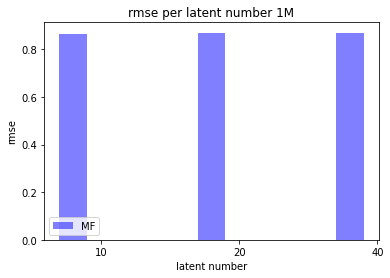

In [14]:
# data to plot
n_groups = 3
RMSE_1m_MF = (min_10L_1m_RMSE,min_20L_1m_RMSE,min_40L_1m_RMSE)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.5

rects1 = plt.bar(index, RMSE_1m_MF, bar_width,
alpha=opacity,
color='b',
label = 'MF')

plt.xlabel('latent number')
plt.ylabel('rmse')
plt.title('rmse per latent number 1M')
plt.xticks(index + bar_width, ('10' ,'20', '40'))
plt.legend()
plt.legend(loc=3)

plt.show()

In [33]:
min_500_100K_RMSE

1.0118466063332117

In [16]:
#find best model 1M 500 auto rec
min_500_1m = [];
for i in range(8):
  min_500_1m.append(np.amin(np.array(hist_file1MAutoRec_list[i][2])))
min_500_1m_RMSE = np.amin(np.array(min_500_1m))
min_500_1m_index = np.where(np.array(min_500_1m) == min_500_1m_RMSE)[0][0]
#find best model 1M 250 auto rec
min_250_1m = [];
for i in range(8,16):
  min_250_1m.append(np.amin(np.array(hist_file1MAutoRec_list[i][2])))
min_250_1m_RMSE = np.amin(np.array(min_250_1m))
min_250_1m_index = np.where(np.array(min_250_1m) == min_250_1m_RMSE)[0][0]
#find best model 1M 100 auto rec
min_100_1m = []
for i in range(16,24):
  min_100_1m.append(np.amin(np.array(hist_file1MAutoRec_list[i][2])))
min_100_1m_RMSE = np.amin(np.array(min_100_1m))
min_100_1m_index = np.where(np.array(min_100_1m) == min_100_1m_RMSE)[0][0]

#find best model 1M 500 auto rec New
min_500_1mNew = [];
for i in range(8):
  min_500_1mNew.append(np.amin(np.array(hist_file1MAutoRecNew_list[i][2])))
min_500_1m_RMSENew = np.amin(np.array(min_500_1mNew))
min_500_1m_indexNew = np.where(np.array(min_500_1mNew) == min_500_1m_RMSENew)[0][0]
#find best model 1M 250 auto rec
min_250_1mNew = [];
for i in range(8,16):
  min_250_1mNew.append(np.amin(np.array(hist_file1MAutoRecNew_list[i][2])))
min_250_1m_RMSENew = np.amin(np.array(min_250_1mNew))
min_250_1m_indexNew = np.where(np.array(min_250_1mNew) == min_250_1m_RMSENew)[0][0]
#find best model 1M 100 auto rec
min_100_1mNew = []
for i in range(16,24):
  min_100_1mNew.append(np.amin(np.array(hist_file1MAutoRecNew_list[i][2])))
min_100_1m_RMSENew = np.amin(np.array(min_100_1mNew))
min_100_1m_indexNew = np.where(np.array(min_100_1mNew) == min_100_1m_RMSENew)[0][0]


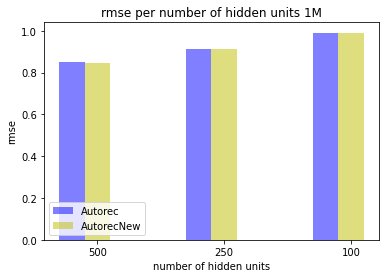

In [17]:
# data to plot
n_groups = 3
RMSE_1m_NEW = (min_500_1m_RMSENew,min_250_1m_RMSENew,min_100_1m_RMSENew)
RMSE_1m = (min_500_1m_RMSE,min_250_1m_RMSE,min_100_1m_RMSE)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.5

rects1 = plt.bar(index, RMSE_1m, bar_width,
alpha=opacity,
color='b',
label = 'Autorec')

rects2 = plt.bar(index +bar_width, RMSE_1m_NEW, bar_width,
alpha=opacity,
color='y',
label = 'AutorecNew')

plt.xlabel('number of hidden units')
plt.ylabel('rmse')
plt.title('rmse per number of hidden units 1M')
plt.xticks(index + bar_width, ('500' ,'250', '100'))
plt.legend()
plt.legend(loc=3)

plt.show()

In [26]:
#find best model 100k 500 auto rec
min_500_100K = [];
for i in range(8):
  min_500_100K.append(np.amin(np.array(hist_file100KAutoRec_list[i][2])))
min_500_100K_RMSE = np.amin(np.array(min_500_100K))
min_500_100K_index = np.where(np.array(min_500_100K) == min_500_100K_RMSE)[0][0]
#find best model 100K 250 auto rec
min_250_100K = [];
for i in range(8,16):
  min_250_100K.append(np.amin(np.array(hist_file100KAutoRec_list[i][2])))
min_250_100K_RMSE = np.amin(np.array(min_250_100K))
min_250_100K_index = np.where(np.array(min_250_100K) == min_250_100K_RMSE)[0][0]
#find best model 100K 100 auto rec
min_100_100K = []
for i in range(16,24):
  min_100_100K.append(np.amin(np.array(hist_file100KAutoRec_list[i][2])))
min_100_100K_RMSE = np.amin(np.array(min_100_100K))
min_100_100K_index = np.where(np.array(min_100_100K) == min_100_100K_RMSE)[0][0]

#find best model 100K 500 auto rec New
min_500_100KNew = [];
for i in range(8):
  min_500_100KNew.append(np.amin(np.array(hist_file100KAutoRecNew_list[i][2])))
min_500_100K_RMSENew = np.amin(np.array(min_500_100KNew))
min_500_100K_indexNew = np.where(np.array(min_500_100KNew) == min_500_100K_RMSENew)[0][0]
#find best model 100K 250 auto rec
min_250_100KNew = [];
for i in range(8,16):
  min_250_100KNew.append(np.amin(np.array(hist_file100KAutoRecNew_list[i][2])))
min_250_100K_RMSENew = np.amin(np.array(min_250_100KNew))
min_250_100K_indexNew = np.where(np.array(min_250_100KNew) == min_250_100K_RMSENew)[0][0]
#find best model 100K 100 auto rec
min_100_100KNew = []
for i in range(16,24):
  min_100_100KNew.append(np.amin(np.array(hist_file100KAutoRecNew_list[i][2])))
min_100_100K_RMSENew = np.amin(np.array(min_100_100KNew))
min_100_100K_indexNew = np.where(np.array(min_100_100KNew) == min_100_100K_RMSENew)[0][0]


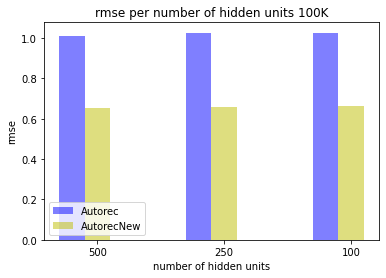

In [ ]:
# data to plot
n_groups = 3
RMSE_100K_NEW = (min_500_100K_RMSENew,min_250_100K_RMSENew,min_100_100K_RMSENew)
RMSE_100K = (min_500_100K_RMSE,min_250_100K_RMSE,min_100_100K_RMSE)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.5

rects1 = plt.bar(index, RMSE_100K, bar_width,
alpha=opacity,
color='b',
label = 'Autorec')

rects2 = plt.bar(index +bar_width, RMSE_100K_NEW, bar_width,
alpha=opacity,
color='y',
label = 'AutorecNew')

plt.xlabel('number of hidden units')
plt.ylabel('rmse')
plt.title('rmse per number of hidden units 100K')
plt.xticks(index + bar_width, ('500' ,'250', '100'))
plt.legend()
plt.legend(loc=3)

plt.show()

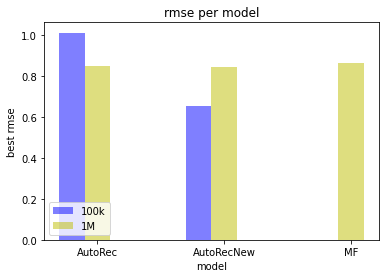

In [ ]:
# data to plot
n_groups = 3
KRMSE = (min_500_100K_RMSE,min_500_100K_RMSENew,0)
MRMSE = (min_500_1m_RMSE,min_500_1m_RMSENew,min_10L_1m_RMSE)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.5

rects1 = plt.bar(index, KRMSE, bar_width,
alpha=opacity,
color='b',
label = '100k')

rects2 = plt.bar(index +bar_width, MRMSE, bar_width,
alpha=opacity,
color='y',
label = '1M')


plt.xlabel('model')
plt.ylabel('best rmse')
plt.title('rmse per model')
plt.xticks(index + bar_width, ('AutoRec' ,'AutoRecNew', 'MF'))
plt.legend()
plt.legend(loc=3)

plt.show()

In [ ]:
train_samples_1m = 1000209 * 0.9
test_samples_1m = 1000209 * 0.1
train_samples_100K = 80000
test_samples_100K = 20000

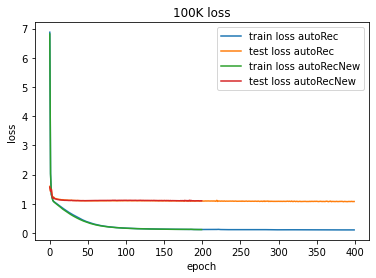

In [ ]:
x = np.arange(400)
y = np.arange(200)
# plot lines
plt.plot(x, hist_file100KAutoRec_list[min_500_100K_index][0]/ train_samples_100K, label  = "train loss autoRec")
plt.plot(x, hist_file100KAutoRec_list[min_500_100K_index][1]/ test_samples_100K, label = "test loss autoRec")
plt.plot(y, hist_file100KAutoRecNew_list[min_500_100K_indexNew][0]/ train_samples_100K, label  = "train loss autoRecNew")
plt.plot(y, hist_file100KAutoRecNew_list[min_500_100K_indexNew][1]/ test_samples_100K, label = "test loss autoRecNew")
plt.title('100K loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

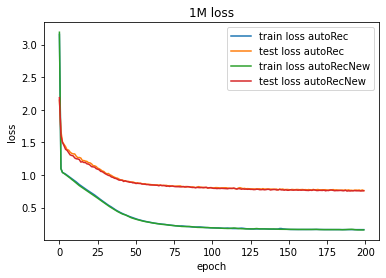

In [ ]:
x = np.arange(200)
# plot lines
plt.plot(x, hist_file1MAutoRec_list[min_500_1m_index][0]/ train_samples_1m, label  = "train loss autoRec")
plt.plot(x, hist_file1MAutoRec_list[min_500_1m_index][1]/ test_samples_1m, label = "test loss autoRec")
plt.plot(x, hist_file1MAutoRecNew_list[min_500_1m_indexNew][0]/ train_samples_1m, label  = "train loss autoRecNew")
plt.plot(x, hist_file1MAutoRecNew_list[min_500_1m_indexNew][1]/ test_samples_1m, label = "test loss autoRecNew")
plt.title('1M loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

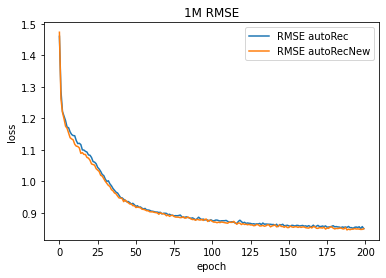

In [ ]:
x = np.arange(200)
# plot lines
plt.plot(x, hist_file1MAutoRec_list[min_500_1m_index][2], label  = "RMSE autoRec")
plt.plot(x, hist_file1MAutoRecNew_list[min_500_1m_indexNew][2], label = "RMSE autoRecNew")
plt.title('1M RMSE')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
len(hist_file100KAutoRecNew_list[min_500_100K_indexNew][1])

200

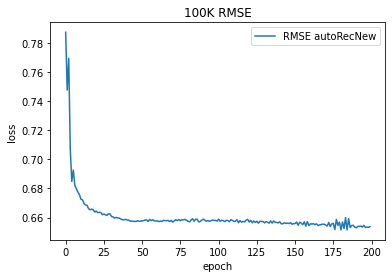

In [ ]:
y = np.arange(200)
# plot lines
plt.plot(y, hist_file100KAutoRecNew_list[min_500_100K_indexNew][2], label = "RMSE autoRecNew")
plt.title('100K RMSE auto rec new')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

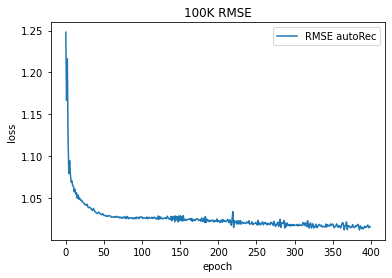

In [ ]:
x = np.arange(400)
# plot lines
plt.plot(x, hist_file100KAutoRec_list[min_500_100K_index][2], label  = "RMSE autoRec")
plt.title('100K RMSE auto rec')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

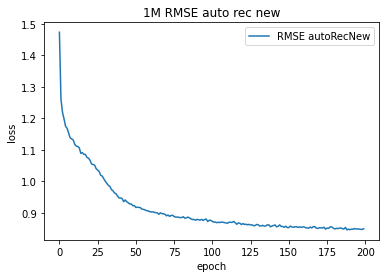

In [ ]:
y = np.arange(200)
# plot lines
plt.plot(y, hist_file1MAutoRecNew_list[min_500_1m_indexNew][2], label = "RMSE autoRecNew")
plt.title('1M RMSE auto rec new')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

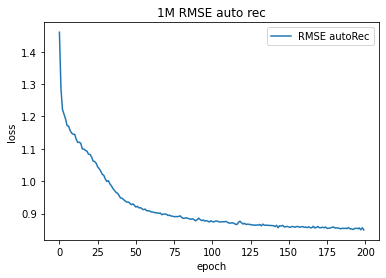

In [ ]:
x = np.arange(200)
# plot lines
plt.plot(x, hist_file1MAutoRec_list[min_500_1m_index][2], label  = "RMSE autoRec")
plt.title('1M RMSE auto rec')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()